# Clasificación de secuencias genómicas

## Temas:
1. Introducción
  - Objetivos
  - Antecedentes y usos
  - Datos genómicos

2. Preprocesamiento básico de secuencias genómicas
  - Resumen de secuencias genómicas y su representación
  - Transformación y extracción de características (tokenización)
  - Actividad: Preparación de un conjunto de datos

3. Modelos de aprendizaje automático para clasificación de secuencias
  - Métodos clásicos de aprendizaje automático (machine learning)
  - Métricas de evaluación de modelos
  - Actividad: Construcción y entrenamiento de modelos

4. Técnicas avanzadas para la clasificación de secuencias
  - Introducción a modelos de aprendizaje profundo con PyTorch
  - Aprendizaje profundo (deep learning)
  - *Transfer learning* con HuggingFace
  ---

# Introducción

## Objetivos:
1. Entender la importancia del proceso de clasificación de secuencias
2. Entender el proceso de preparación de conjuntos de datos para la clasificación de secuencias genómicas
3. Comprender las distintas estrategias disponibles para la clasificación de secuencias
4. Implementar un algoritmo de clasificación de secuencias codificantes vs. no codificantes exitosamente

## Antecedentes
El término **genoma** se refiere a todo el material genético heredable de un ser vivo. La principal diferencia entre la genética y la genómica es el objetivo de estudio. El primero estudia **genes** individuales, así como sus productos y consecuencias de su variación. Mientras que la genómica se centra en todos los elementos que se encuentran en el genóma y cómo estos interaccionan [1]. La rama de la **genómica funcional** estudia cómo los genes y las regiones intergénicas, afectados por el ambiente resultan en fenotipos específicos, es decir, las características visibles de un organismo (color de piel, de ojos, enfermedades manifestadas, etc.) [2].

<figure>
<img    src="images/dna_double_helix.jpg"
        width=500
        height=500>
<figcaption>Fig. 1: Imagen generada de la doble hélice de la estructura del ADN.
</figure>

Tradicionalmente la clasificación de secuencias era un proceso predominantemente estadístico, sin embargo, en los últimos años el uso de herramientas de aprendizaje automático, específicamente de aprendizaje profundo, han servido para identificar y clasificar numerosos elementos genómicos. Por ejemplo, elementos como promotores, potenciadores, factores de transcripción, entre otros, han sido de mucha utilidad para comprobar la efectividad de estas novedosas estrategias [3].

<figure>
<img    src="images/IA_ML_DL.png"
        width=500
        height=500>
<figcaption>Fig. 2: Diagrama de Venn del paradigma de inteligencia artificial.
</figure>

En este taller veremos cuál es el proceso para la clasificación de secuencias genómicas desde el minado y preporcesamiento de los datos, hasta el uso de herramientas más avanzadas. De manera general, este procedimiento se resume en los siguientes pasos:

1. Entender el problema
2. Adquisición y/o búsqueda de datos
3. Pre-procesamiento de datos
4. Extracción de características
5. Elección de modelo o arquitectura
6. Entrenamiento del modelo
7. Evaluación del modelo
8. Despliegue del modelo (en aplicaciones prácticas e industriales)

<figure>
<img    src="images/ml_workflow.png"
        width=1200
        height=200>
<figcaption>Fig. 3: Flujo de trabajo convencional en el uso de herramientas de ML en aplicaciones biomédicas [4].
</figure>

---

# Preprocesamiento básico de secuencias genómicas

In [1]:
# Importaremos algunas librerías que nos serán de mucha utilidad
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
import gzip
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn import datasets, decomposition
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import ast

# Instalamos una librería que no está disponible de forma predeterminada en Colab y la importamos
!pip install biopython
from Bio import SeqIO

## Secuencias codificantes vs. no codificantes
El conjunto de datos con el que trabajaremos está disponible en la base de datos pública de Ensembl, disponible [aquí](https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/) en su formato crudo.

El que utilizaremos para este taller está disponible en [esta](https://drive.google.com/drive/folders/1hYwhOeg5xHI7nBzQHFWOGZyXCMbC3Mib?usp=sharing) carpeta de drive. El procedimiento de cómo acceder al conjunto de datos se muestra a continuación.

Al hacer click en el enlace, se abrirá el navegador de internet en una dirección de una carpeta almacenada en Google Drive. A continuación, dar click en la parte superior con el texto ***sequence_classification_dataset***. Seleccionar el apartado ***Organizar***, y finalmente ***Añadir acceso directo***.

<figure>
<img    src="images/drive_1.png"
        width=1000
        height=600>
<figcaption>Fig. 4: Ilustración de pasos a seguir para añadir acceso directo del conjunto de datos a la unidad de Google Drive (1).
</figure>


Después se abrirá una pequeña ventana para indicar la dirección donde el acceso directo al conjunto de datos será puesto dentro de la unidad. Seleccionar ***Mi unidad*** y ***Añadir***.

<figure>
<img    src="images/drive_2.png"
        width=600
        height=500>
<figcaption>Fig. 5: Ilustración de pasos a seguir para añadir acceso directo del conjunto de datos a la unidad de Google Drive (2).
</figure>

Ahora montaremos nuestra unidad de Google Drive para poder trabajar con los conjuntos de datos. Se abrirán algunas pestañas y ventanas emergentes de **Colab** para pedir acceso a nuestro almacenamiento en la nube. Aceptamos todos los permisos correspondientes.

In [ ]:
# Importar datos de unidad de google drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Direcciones de los conjuntos de datos
gen_path = "/content/drive/MyDrive/sequence_classification_dataset/"
ncrna_path = gen_path + "ncrna/Homo_sapiens.GRCh38.ncrna.fa.gz"
cdna_path = gen_path + "cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz"

In [3]:
# Leemos el archivo que contiene las secuencias con las que trabajeremos
with gzip.open(ncrna_path, 'rt') as file_handler:
    ncrna_seq = [record for record in SeqIO.parse(file_handler, "fasta")]

print(ncrna_seq[:5])

[SeqRecord(seq=Seq('GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGCAGATAAGC...TTG'), id='ENST00000616830.1', name='ENST00000616830.1', description='ENST00000616830.1 ncrna scaffold:GRCh38:KI270744.1:51009:51114:-1 gene:ENSG00000278625.1 gene_biotype:snRNA transcript_biotype:snRNA gene_symbol:U6 description:U6 spliceosomal RNA [Source:RFAM;Acc:RF00026]', dbxrefs=[]), SeqRecord(seq=Seq('ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTCCCAGGGCA...GTA'), id='ENST00000612925.1', name='ENST00000612925.1', description='ENST00000612925.1 ncrna scaffold:GRCh38:KI270750.1:148668:148843:1 gene:ENSG00000277374.1 gene_biotype:snRNA transcript_biotype:snRNA gene_symbol:U1 description:U1 spliceosomal RNA [Source:RFAM;Acc:RF00003]', dbxrefs=[]), SeqRecord(seq=Seq('GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAGAAAGTTAG...TTG'), id='ENST00000616468.1', name='ENST00000616468.1', description='ENST00000616468.1 ncrna scaffold:GRCh38:GL000213.1:127840:127946:-1 gene:ENSG00000278793.1 gene_biotype:snRNA transcri

In [4]:
# En este caso, la única información que nos interesa es sólo la secuencia, por lo tanto debemos especificarlo
with gzip.open(ncrna_path, 'rt') as file_handler:
    ncrna_seq = [str(record.seq)for record in SeqIO.parse(file_handler, "fasta")]

print(ncrna_seq[:5])

['GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGCAGATAAGCATGGTTACTGCCTAGGGATGGCACACAAATTCAGAAAGCATTCCATATTTTG', 'ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTCCCAGGGCAAGGCTTATCCATTCCACTCTGGATCCATCATAGGGATATGCTGATCCCTGGAATTGCCCCAAATGTGGGAAGCTCTACTGCAAAATTTTTGGTAGTGAGCGATGGCATTATGCATTCATGTA', 'GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAGAAAGTTAGCATGGCTTCTGCATAAGGAGGCAGCACAACTCTTTGAGGCATTCCATATTTTG', 'CACTTTACCTGGCAGGGGAGAGACCGTGGTCACGAAGGGGGTTCTCCCAGAGTGAAGCTTCTTCATCGCACTCTAGAGTTGCTGATTCCTGTGATTTCCTCCATGTGGGAAACGGTGTTTGTGCTAGAAGAGGCTGCGCTCTTT', 'ATACTTACCTGGCAGGGGAGATACCATGATCACGAAGGTGGTTTTCCCAGGGCGAGGCTTATCCATTGCACTCCGGATGTGCTGACCCCTGCGATTTCCCCAAATGTGGGAAACTCGACTGCATAATTTGTGGTAGTGGGGGACTGCGTTCGCGCTTTCCCCTG']


**Hasta aquí, solo hemos extraído las secuencias *no codificantes*. Repetiremos el mismo proceso con las secuencias *codificantes*.**

In [5]:
# Extraemos únicamente las secuencias del conjunto de datos de secuencias codificantes
with gzip.open(cdna_path, 'rt') as file_handler:
    cdna_seq = [str(record.seq) for record in SeqIO.parse(file_handler, "fasta")]

print(cdna_seq[:5])

['GAAATAGT', 'ACTGGGGGATACG', 'CCTTCCTAC', 'GGGACAGGGGGC', 'GGGACAGGGGGC']


**Muy bien, ya se extrajeron nuestras secuencias, pero no servirán de mucho almacenandolas solamente en listas de Python, además se les debe asignar algun tipo de valor o *etiqueta* para poder identificarlas más fácilmente. Por lo tanto ahora se reorganizarán en una estructura de datos conocida como *DataFrame*, apoyándonos de otra estrucura conocida como *diccionario*.**

In [6]:
# Con ayuda del diccionario y la librería numpy, asignamos a las secuencias no codificantes un valor numérico de 0
max_len = 1000
nc_sequences_dict = {'sequences': ncrna_seq[:max_len],
                     'value': np.zeros(max_len,dtype=np.int8)}

# Asímismo, asignamos un valor número con valor de 1 a las secuencias codificantes
c_sequences_dict = {'sequences': cdna_seq[:max_len],
                    'value': np.ones(max_len,dtype=np.int8)}

# Creamos el dataframe general a partir de la unión de los dataframe de cada tipo de secuencia
sequences_df = pd.concat([pd.DataFrame(nc_sequences_dict), pd.DataFrame(c_sequences_dict)])

# Se imprime una vista previa de los primeros 5 elementos
sequences_df.head()

,sequences,value
0,GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGC...,0
1,ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTC...,0
2,GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAG...,0
3,CACTTTACCTGGCAGGGGAGAGACCGTGGTCACGAAGGGGGTTCTC...,0
4,ATACTTACCTGGCAGGGGAGATACCATGATCACGAAGGTGGTTTTC...,0


In [7]:
# Se imprime una vista previa de los últimos 5 elementos
sequences_df.tail()

,sequences,value
995,AGGGAAGCTCCAGCTGTCCCTCCCGCAGTTGGCCCTGTGGTGTTCC...,1
996,AGGGAAGCTCCAGCTGTCCCTCCCGCAGTTGGCCCTGTGGTGTTCC...,1
997,GCCGGAAGCAGAAGGACCTCTCTCCCCTAGCTCTCTTTTTCTTGCA...,1
998,TCTGTCTGTTAGTACAGAGCTCTTATTCAGCCACTAGCTCGGCCTT...,1
999,TCCAAACCCGGCAATGTTGGTGGCTCTTGCATTCCTCTGGATGAGC...,1


**Ahora que ya tenemos nuestras secuencias con sus etiquetas correspondientes pasaremos al proceso de *tokenización*. Este proceso consiste en pasar de caracteres de texto a números interpretables por una computadora o algoritmo. Para ello, utilizaremos la librería *transformers* de [HuggingFace](https://huggingface.co/docs/transformers/index).**

## Tokenización

In [8]:
# Declaramos y creamos el tokenizador
checkpoint = 'LongSafari/hyenadna-tiny-1k-seqlen-hf'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True, padding=True, truncation=True)

/home/msr/miniconda3/envs/deep_learning/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# Probamos con una secuencia cualquiera de nuestro conjunto de datos
sequence = sequences_df["sequences"].iloc[493]
tokenized = tokenizer(sequence)["input_ids"]
print(tokenized)

[9, 10, 9, 8, 10, 8, 7, 8, 10, 10, 8, 7, 9, 8, 7, 9, 8, 7, 10, 7, 10, 7, 10, 7, 8, 10, 7, 7, 7, 7, 10, 10, 9, 9, 7, 7, 10, 9, 7, 10, 7, 8, 7, 7, 7, 9, 7, 7, 9, 7, 10, 10, 7, 9, 8, 7, 10, 9, 9, 8, 8, 8, 8, 10, 9, 8, 9, 8, 7, 7, 9, 9, 7, 10, 9, 7, 8, 7, 10, 7, 10, 7, 8, 7, 10, 10, 10, 9, 10, 9, 7, 7, 9, 8, 7, 10, 10, 8, 10, 9, 10, 7, 10, 10, 10, 10, 10, 1]


In [10]:
# Ahora tokenizamos todas nuestras secuencias para tener las representaciones computables
tokenized_sequences = [tokenizer(sequence)["input_ids"] for sequence in sequences_df["sequences"]]
# Imprimimos la primera secuencia tokenizada
print(tokenized_sequences[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (1736 > 1026). Running this sequence through the model will result in indexing errors


[9, 10, 7, 8, 10, 10, 7, 10, 10, 10, 8, 7, 7, 8, 7, 9, 8, 7, 8, 7, 10, 7, 10, 10, 10, 10, 7, 7, 7, 10, 10, 9, 9, 7, 10, 8, 7, 7, 10, 7, 8, 7, 9, 7, 9, 8, 7, 9, 7, 10, 7, 7, 9, 8, 7, 10, 9, 9, 10, 10, 7, 8, 10, 9, 8, 8, 10, 7, 9, 9, 9, 7, 10, 9, 9, 8, 7, 8, 7, 8, 7, 7, 7, 10, 10, 8, 7, 9, 7, 7, 7, 9, 8, 7, 10, 10, 8, 8, 7, 10, 7, 10, 10, 10, 10, 9, 1]


In [11]:
# Añadimos una nueva columna a nuestro dataframe con las secuencias tokenizadas
sequences_df["tokenized"] = tokenized_sequences
sequences_df.head()

,sequences,value,tokenized
0,GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGC...,0,"[9, 10, 7, 8, 10, 10, 7, 10, 10, 10, 8, 7, 7, ..."
1,ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTC...,0,"[7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,..."
2,GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAG...,0,"[9, 10, 9, 8, 8, 10, 9, 8, 10, 10, 10, 9, 9, 8..."
3,CACTTTACCTGGCAGGGGAGAGACCGTGGTCACGAAGGGGGTTCTC...,0,"[8, 7, 8, 10, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,..."
4,ATACTTACCTGGCAGGGGAGATACCATGATCACGAAGGTGGTTTTC...,0,"[7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,..."


**Con fines ilustrativos se mostrará una secuencia original y su contraparte tokenizada y decodificada, es decir, pasar de la representación numérica a la de caracteres de texto.**

In [12]:
# Imprimimos la secuencia original y la decodificación de la tokenizada
print(sequences_df["sequences"].iloc[0], "\n", 
      tokenizer.decode(sequences_df["tokenized"].iloc[0]))

GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGCAGATAAGCATGGTTACTGCCTAGGGATGGCACACAAATTCAGAAAGCATTCCATATTTTG 
 GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGCAGATAAGCATGGTTACTGCCTAGGGATGGCACACAAATTCAGAAAGCATTCCATATTTTG[SEP]


**Ahora veremos si existe algún patrón o propiedades intrínsecas en las secuencias que las diferencíe aplicando un método de reducción dimensional como lo es el *análisis de componentes principales* (PCA).**

In [13]:
# Determinamos el largo máximo de las secuencias
max_len = max(sequences_df['tokenized'].apply(len))

# Rellenamos las secuencias más cortas con el valor del token de padeo del tokenizador (padding)
pad_token = tokenizer.pad_token_id
padded_lists = sequences_df['tokenized'].apply(lambda x: x + [pad_token]*(max_len - len(x)))
padded_lists


0      [9, 10, 7, 8, 10, 10, 7, 10, 10, 10, 8, 7, 7, ...
1      [7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,...
2      [9, 10, 9, 8, 8, 10, 9, 8, 10, 10, 10, 9, 9, 8...
3      [8, 7, 8, 10, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,...
4      [7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,...
                             ...                        
995    [7, 9, 9, 9, 7, 7, 9, 8, 10, 8, 8, 7, 9, 8, 10...
996    [7, 9, 9, 9, 7, 7, 9, 8, 10, 8, 8, 7, 9, 8, 10...
997    [9, 8, 8, 9, 9, 7, 7, 9, 8, 7, 9, 7, 7, 9, 9, ...
998    [10, 8, 10, 9, 10, 8, 10, 9, 10, 10, 7, 9, 10,...
999    [10, 8, 8, 7, 7, 7, 8, 8, 8, 9, 9, 8, 7, 7, 10...
Name: tokenized, Length: 2000, dtype: object

In [14]:
# Convertimos las listas rellenadas a un arreglo de numpy
X = np.array(padded_lists.tolist())

In [15]:
# Creamos el objeto de PCA y lo aplicamos a nuestro arreglo
pca = decomposition.PCA(n_components=3)
principal_components = pca.fit_transform(X)


In [16]:
# Create a DataFrame with the principal components and the target labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3'])
pca_df['Target'] = sequences_df["value"].to_list()

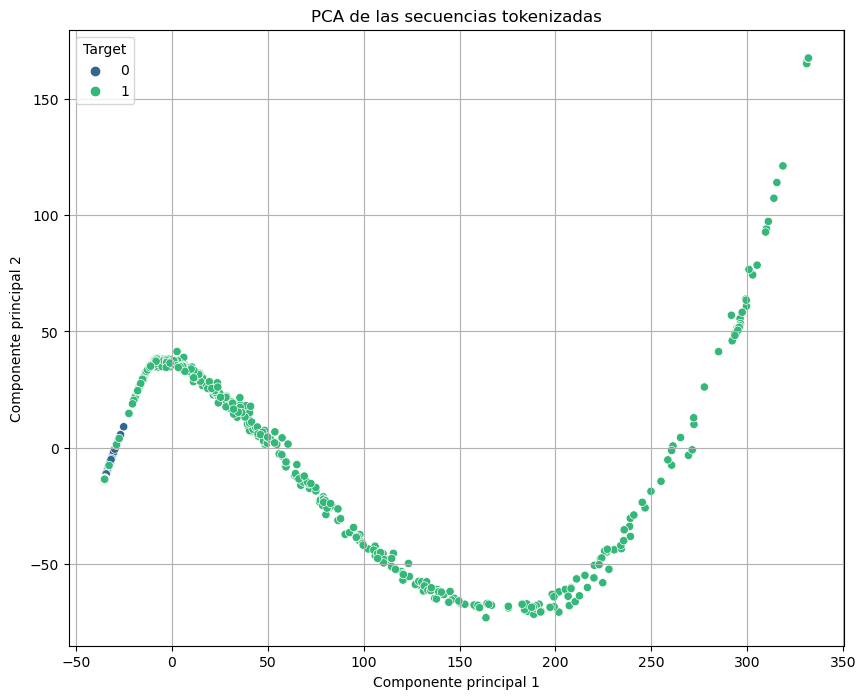

In [17]:
# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC3', hue='Target', palette='viridis', data=pca_df, legend='full')

# Customize the plot
plt.title('PCA de las secuencias tokenizadas')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
#plt.legend(title='Target', labels=labels)
plt.grid(True)
plt.show()

---

# Modelos de aprendizaje automático para la clasificación de secuencias
Los métodos de aprendizaje automático se dividen en dos clasificaciones básicas: **aprendizaje supervisado** y **aprendizaje *no* supervisado**. La principal diferencia entre estos es que en el primero, al momento de su implementación, se proporcionan las etiquetas que representan *la verdad* para posteriormente evaluar el rendimiento del método mediante comparación de resultados del modelo. Mientras que en el segundo no se entrega ningún tipo de etiqueta asociada a los datos, sino que el método analiza las propiedades y patrones intrínsecos de los datos para realizar predicciones. El PCA implementado anteriormente pertenece a la categoría de no supervisados.

## Máquinas de soporte de vectores

Son un tipo de algoritmo de **aprendizaje supervisado**, estos manejan conjuntos de datos de alta dimensionalidad. Cararacterizado por ser un excelente clasificador.


*   Busca encontrar un **hiperplano que maximice** el margen de discriminación entre las clases de datos en un espacio de características.
*   Utiliza la función ***hinge loss*** para penalizar las clasificaciones incorrectas.
*   Usa como **hiperparámetro** *C*, que es el costo.
*   Si *C* es muy grande elegirá un margen estricto, si es pequeño se optimizará el margen incluso si el hiperplano clasifica mal.

<figure>
<img src="images/SVM in R.png" width=500, height=400>
<figcaption>Fig. 6: Representación gráfica del funcionamiento de las máquinas de soporte de vectores.
</figure>

### Ejemplo de implementación de máquina de soporte de vectores

In [35]:
# Leeremos un nuevo archivo con los datos que produjimos ayer
sequences_df = pd.read_csv(gen_path + "genomic_sequences_dataset.csv")
sequences_df.head()

,sequences,value,tokenized,padded_sequences
0,GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGC...,0,"[9, 10, 7, 8, 10, 10, 7, 10, 10, 10, 8, 7, 7, ...","[9, 10, 7, 8, 10, 10, 7, 10, 10, 10, 8, 7, 7, ..."
1,ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTC...,0,"[7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,...","[7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,..."
2,GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAG...,0,"[9, 10, 9, 8, 8, 10, 9, 8, 10, 10, 10, 9, 9, 8...","[9, 10, 9, 8, 8, 10, 9, 8, 10, 10, 10, 9, 9, 8..."
3,CACTTTACCTGGCAGGGGAGAGACCGTGGTCACGAAGGGGGTTCTC...,0,"[8, 7, 8, 10, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,...","[8, 7, 8, 10, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,..."
4,ATACTTACCTGGCAGGGGAGATACCATGATCACGAAGGTGGTTTTC...,0,"[7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,...","[7, 10, 7, 8, 10, 10, 7, 8, 8, 10, 9, 9, 8, 7,..."


In [38]:
# Al importar el csv las listas de números se interpretan como cadenas de texto, para arreglar este problema aplicamos la siguiente función
sequences_df["padded_sequences"] = sequences_df["padded_sequences"].apply(ast.literal_eval)
# Verificamos que en realidad sí se convirtió de nuevo en una lista
print(sequences_df["padded_sequences"][0]) 

[9, 10, 7, 8, 10, 10, 7, 10, 10, 10, 8, 7, 7, 8, 7, 9, 8, 7, 8, 7, 10, 7, 10, 10, 10, 10, 7, 7, 7, 10, 10, 9, 9, 7, 10, 8, 7, 7, 10, 7, 8, 7, 9, 7, 9, 8, 7, 9, 7, 10, 7, 7, 9, 8, 7, 10, 9, 9, 10, 10, 7, 8, 10, 9, 8, 8, 10, 7, 9, 9, 9, 7, 10, 9, 9, 8, 7, 8, 7, 8, 7, 7, 7, 10, 10, 8, 7, 9, 7, 7, 7, 9, 8, 7, 10, 10, 8, 8, 7, 10, 7, 10, 10, 10, 10, 9, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [39]:
# Declaramos las entradas (X) del modelo y las etiquetas con las que posteriormente se evaluará el rendimiento (y)
X = np.array(sequences_df["padded_sequences"].tolist())
y = sequences_df["value"].copy()

# Se divide el conjunto de datos en conjuntos de entrenamiento y prueba con una proporcion de 80-20, es decir,
# el 80% será de entrenamiento y el 20% restante será de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

In [40]:
# Construir el modelo y ajustarlo a los datos de entrenamiento
svc_model = SVC(probability=True).fit(X_train, y_train)

# Utilizar el modelo para generar predicciones en el conjunto de datos de prueba
svc_y_pred = svc_model.predict(X_test)

### Evaluación del rendimiento del modelo

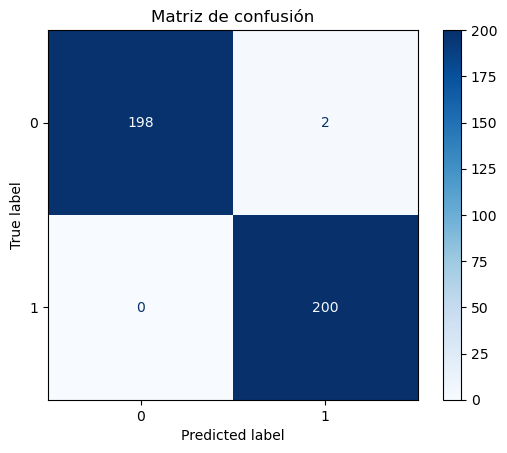

In [41]:
# Cálculo de la matriz de confusión, tomando como parámetros las etiquetas del cojunto de prueba, y las
# predicciones realizadas por el modelo en el conjunto de prueba
svc_cm = confusion_matrix(y_test, svc_y_pred, labels=svc_model.classes_)

# Crear estructura de la matriz de confusión
svc_disp = ConfusionMatrixDisplay(confusion_matrix=svc_cm,
                                  display_labels=svc_model.classes_)

# Graficar matriz de confusión
svc_disp.plot(values_format='', cmap="Blues")
plt.title("Matriz de confusión")
plt.show()

In [42]:
# Crear un reporte de clasificación del modelo de SVM
target_names = ['No codificantes', 'Codificantes']
print(classification_report(y_test, svc_y_pred, target_names=target_names))

                 precision    recall  f1-score   support

No codificantes       1.00      0.99      0.99       200
   Codificantes       0.99      1.00      1.00       200

       accuracy                           0.99       400
      macro avg       1.00      0.99      0.99       400
   weighted avg       1.00      0.99      0.99       400



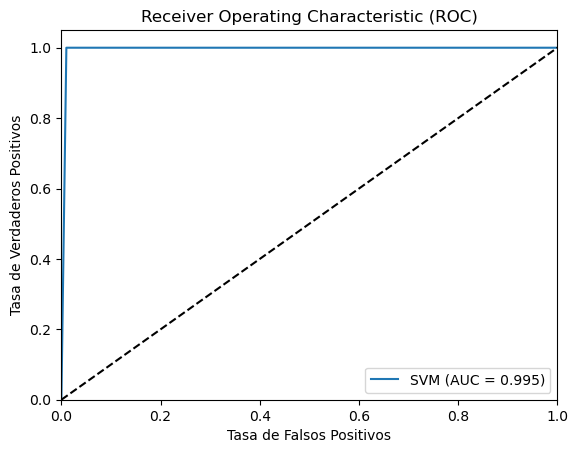

In [22]:
# Graficar curva ROC del rendimiento del modelo SVM
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_y_pred)
svc_auc = roc_auc_score(y_test, svc_y_pred)

# Graficar curva ROC
plt.plot(svc_fpr, svc_tpr, label='SVM (AUC = %0.3f)' % svc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Regresión lineal y logística

La **regresión lineal**, es un algoritmo es utilizado para predecir valores continuos encontrando la mejor linea de ajuste para los datos de salida ($y = mx + b$).

*   **Parámetros**: $m$ y $b$ (valores inicialmente aleatorios).
*   **Cálculo de la función de costo**: Para evaluar que tan bien se ajusta la linea a los datos (*error cuadrático medio*).

La **regresión logística** se usa para clasificaciones binarias (o sea dos conjuntos de datos) buscando la propabilidad de pertenencia a una clase.

*   Se utiliza la función sigmoide para el calculo de probabilidad.
*   Parámetros: $m$ y $b$
*   **Función de costo**: Evalua la eficacia de la predicción (*entropia cruzada*).
*   Optimización de parámetros: Minimiza la función de costo (*gradiente descendente*)*

<figure>
<img src="images/logistic_regression.png" width=600, height=400>
<figcaption>Fig. 7: Representación gráfica de la regresión logística.
</figure>

### Ejemplo de implementación de regresión logística para la clasificación de secuencias

In [23]:
# Construcción de un modelo de regresión logística y ajustarlo a los datos (entrenamiento)
logreg = LogisticRegression(max_iter=100).fit(X_train, y_train)

/home/msr/miniconda3/envs/deep_learning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# Usar el modelo de regresión logística para obtener predicciones en el conjunto de prueba
logreg_y_pred = logreg.predict(X_test)

### Evaluación del modelo de regresión logística

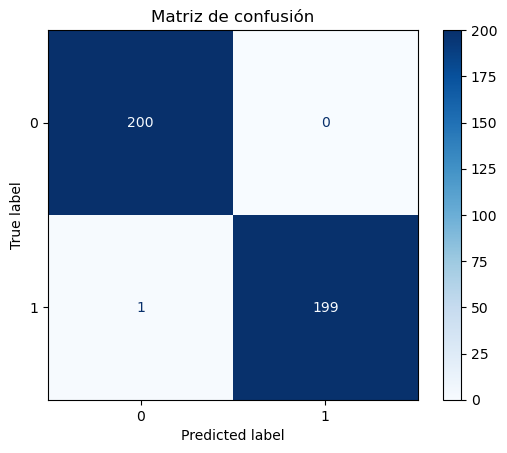

In [25]:
# Calcular la matriz de confusión para evaluar el rendimiento del modelo
log_cm = confusion_matrix(y_test, logreg_y_pred, labels=logreg.classes_)

# Crear arreglo de la matriz de confusión
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,
                                  display_labels=logreg.classes_)

# Gráficar la matriz de confusión
log_disp.plot(values_format='', cmap="Blues")
plt.title("Matriz de confusión")
plt.show()

In [26]:
# Crear un reporte de la clasificación del modelo de regresión logística
print(classification_report(y_test, logreg_y_pred, target_names=target_names))

                 precision    recall  f1-score   support

No codificantes       1.00      1.00      1.00       200
   Codificantes       1.00      0.99      1.00       200

       accuracy                           1.00       400
      macro avg       1.00      1.00      1.00       400
   weighted avg       1.00      1.00      1.00       400



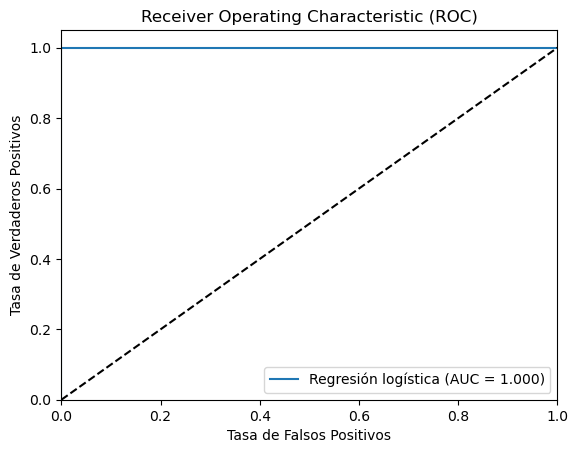

In [27]:
# Graficar curva ROC del rendimiento del modelo de regresión logística

log_probs = logreg.predict_proba(X_test)[:, 1]
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
log_auc = roc_auc_score(y_test, log_probs)

plt.plot(log_fpr, log_tpr, label='Regresión logística (AUC = %0.3f)' % log_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### Random Forest

Es otro algoritmo de aprendizaje supervisado que combina multiples **árboles de desición**, cada uno entrenado por separado con diferentes datos.
Basado en lógica binaria multivariante.

*   Utiliza **bagging**, una técnica que genera múltiples conjuntos de datos de la base de datos original.
*   Para cada conjunto, se construye un árbol, con un subconjunto de **características** para cada uno.

Para cada predicción, cada árbol realiza una propia y, dependiendo del algoritmo (si es de clasificación o regresión), la predicción final se dará por votación o promedio.

<figure>
<img src="images/how-random-forest-classifier-work.png" width=600, height=400>
<figcaption>Fig. 8: Representación gráfica de un random forest.
</figure>

##### Ejemplo de implementación con random forest

In [29]:
# Construir un random forest y ajustarlo de acuerdo a los datos de entrenamiento
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# Utilizar el modelo para realizar predicciones para el conjunto de datos de prueba
rf_y_pred = rf_model.predict(X_test)

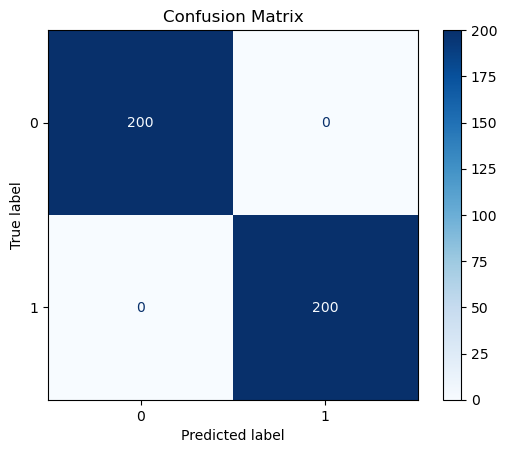

In [30]:
# Calcular matriz de confusión
rf_cm = confusion_matrix(y_test, rf_y_pred, labels=rf_model.classes_)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm,
                                  display_labels=rf_model.classes_)

# Graficar matriz de confusión
rf_disp.plot(values_format='', cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [31]:
# Crear un reporte de clasificación del modelo de Random Forest
print(classification_report(y_test, rf_y_pred, target_names=target_names))

                 precision    recall  f1-score   support

No codificantes       1.00      1.00      1.00       200
   Codificantes       1.00      1.00      1.00       200

       accuracy                           1.00       400
      macro avg       1.00      1.00      1.00       400
   weighted avg       1.00      1.00      1.00       400



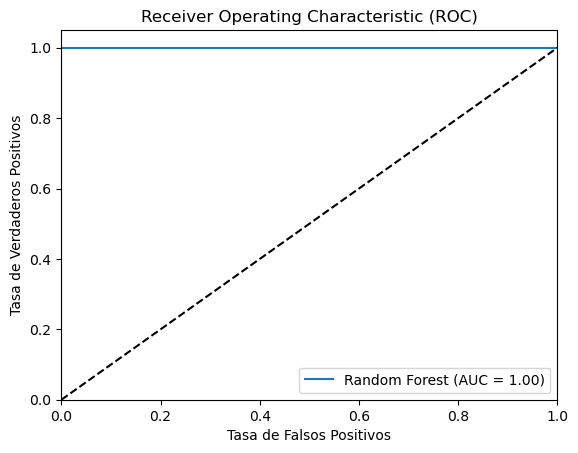

In [34]:
# Calcular curva ROC del Random Forest
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# Graficar curva ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Métricas de evaluación de modelos
### Exactitud (*Accuracy*)

Es una medida que informa acerca del número de **clasificaciones correctas** del número total de clasificaciones hechas por el modelo . Su valor es representado mediante porcentajes que van del 0 al 100%.

<figure>
<img src="images/accuracy.png" width=512, height=512>
<figcaption> Fig. 9: Representación gráfica de la exactitud de un modelo
</figure>

### Sensibilidad

La especificidad es la verdadera tasa negativa de una prueba. En otras palabras, representa la proporción de personas sin la enfermedad, que tendrá un resultado negativo. Al igual que para la sensibilidad, los valores oscilan entre 0 y 100%.

<figure>
<img src="images/false-positive-blog-image-ss1-1024x512.png"
width=512
height=300>
<figcaption> Fig. 10: Relación entre sensibilidad y especificidad
</figure>

### Especificidad

Es la tasa de positividad verdadera de una prueba. Es decir, cuántos sujetos con una enfermedad son realmente identificados como portadores de la enfermedad por la prueba. Los valores oscilan entre 0 y 100%. Se calcula de la siguiente forma:

$$Especificidad = \frac{Verdaderos\ negativos}{Verdaderos\ negativos + Falsos\ positivos}$$

### Precisión

Es una medida que nos dice de todos los casos previstos, cuántos son casos reales. Rango de valores posibles de 0 a 1.

$$Precisión = \frac{Verdaderos\ positivos}{Verdaderos\ Positivos + Falsos\ Positivos}$$

### Matriz de confusión
<figure>
<img    src="images/Confusion_matrix.png"
        width=710
        height=600>
<figcaption> Fig. 11: Propiedades y explicación de los componentes de una matriz de confusión
</figure>

### *Recall*
Es una medida informativa que indica el número de *casos* identificados por el modelo con respecto del número de *casos* real. Por ejemplo, una pregunta que el *recall* responde es: "Del número total de pacientes con cáncer, ¿cuántos fueron correctamente identificados por el modelo?".

### Curva ROC (*Area under the receiver operator curve*)

Es una medida que detalla qué tan sensible y específico es el modelo. Normalmente se detalla en una gráfica en donde el eje $x$ representa las predicciones erróneas, y el $y$ las positivas. Una métrica mala en términos de sensitividad y especificidad se encontraría por debajo de una valor de 0.5. Análogamente, sería como tirar un volado.

<figure>
<img src="images/AUCROC.webp"
width=620, height=480>
<figcaption> Fig. 12: Representación explicativa de la curva ROC
</figure>

---

# Ejercicio
Replicar los procesos de:
* Tokenización
* Elección y ajuste de modelo
* Evaluación del modelo

In [ ]:
# Importar datos de unidad de google drive
# EJECUTAR SOLAMENTE SI NO SE HA MONTADO LA UNIDAD DE GOOGLE DRIVE AÚN
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Importamos el conjunto de datos para esta actividad e imprimimos las primeras 5 líneas
gen_path = "/content/drive/MyDrive/sequence_classification_dataset/"
screen_df = pd.read_csv(_ + "screen_encode_database.csv")
screen_df.head()

,sequences,labels
0,ATTTCAGATCTCTAGAACTATCCATCAGTGAAATGGATTGCAAATA...,0
1,AAAGGGTTGCTTGACCCACAGATGTGAAGCTGAGGCTGAAGGAGAC...,0
2,CATTTTCCTGAGAGGAAAGCTTTCCCACATTATTCAGCTTCTGAAA...,0
3,CACGTCAAGCTGTGCAGGGAATGCTAAACAGAGGCAGATCTAAACT...,0
4,CTTTATTTCAACACGGTGGCAGGGGTCATCTGTTCCTGCCTGCTCT...,0


### Tokenización

In [3]:
# Declaramos y creamos el tokenizador
checkpoint = 'LongSafari/hyenadna-tiny-1k-seqlen-hf'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True, padding=True, truncation=True)

/home/msr/miniconda3/envs/deep_learning/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# Ahora tokenizamos todas nuestras secuencias para tener las representaciones computables
tokenized_sequences = [tokenizer(_)["input_ids"] for sequence in _["sequences"]]
# Imprimimos la primera secuencia tokenizada para asegurarnos de que nuestro tokenizador funciona
print(tokenized_sequences[0])

[7, 10, 10, 10, 8, 7, 9, 7, 10, 8, 10, 8, 10, 7, 9, 7, 7, 8, 10, 7, 10, 8, 8, 7, 10, 8, 7, 9, 10, 9, 7, 7, 7, 10, 9, 9, 7, 10, 10, 9, 8, 7, 7, 7, 10, 7, 8, 7, 7, 7, 9, 7, 9, 10, 7, 7, 10, 7, 8, 8, 7, 10, 9, 10, 8, 7, 8, 10, 10, 7, 7, 9, 7, 7, 10, 7, 9, 7, 7, 10, 8, 7, 10, 9, 9, 7, 8, 9, 7, 9, 9, 8, 10, 9, 8, 8, 7, 8, 8, 10, 9, 8, 10, 9, 10, 10, 9, 9, 9, 9, 9, 8, 8, 7, 8, 10, 9, 8, 7, 9, 7, 7, 9, 7, 7, 7, 10, 10, 8, 8, 7, 9, 7, 7, 8, 7, 8, 10, 9, 9, 7, 8, 10, 9, 9, 7, 9, 7, 9, 8, 7, 8, 8, 1]


In [5]:
# Añadir la una nueva columna a nuestro dataframe con las secuencias tokenizadas
screen_df["tokenized"] = _
screen_df.head()

,sequences,labels,tokenized
0,ATTTCAGATCTCTAGAACTATCCATCAGTGAAATGGATTGCAAATA...,0,"[7, 10, 10, 10, 8, 7, 9, 7, 10, 8, 10, 8, 10, ..."
1,AAAGGGTTGCTTGACCCACAGATGTGAAGCTGAGGCTGAAGGAGAC...,0,"[7, 7, 7, 9, 9, 9, 10, 10, 9, 8, 10, 10, 9, 7,..."
2,CATTTTCCTGAGAGGAAAGCTTTCCCACATTATTCAGCTTCTGAAA...,0,"[8, 7, 10, 10, 10, 10, 8, 8, 10, 9, 7, 9, 7, 9..."
3,CACGTCAAGCTGTGCAGGGAATGCTAAACAGAGGCAGATCTAAACT...,0,"[8, 7, 8, 9, 10, 8, 7, 7, 9, 8, 10, 9, 10, 9, ..."
4,CTTTATTTCAACACGGTGGCAGGGGTCATCTGTTCCTGCCTGCTCT...,0,"[8, 10, 10, 10, 7, 10, 10, 10, 8, 7, 7, 8, 7, ..."


### Rellenar las con el token de *padding* las secuencias más cortas

In [6]:
# Determinamos el largo máximo de las secuencias
max_len = max(_['tokenized'].apply(len))

# Rellenamos las secuencias más cortas con el valor del token de padeo del tokenizador (padding)
pad_token = tokenizer.pad_token_id
padded_lists = _['tokenized'].apply(lambda x: x + [pad_token]*(max_len - len(x)))
padded_lists

0       [7, 10, 10, 10, 8, 7, 9, 7, 10, 8, 10, 8, 10, ...
1       [7, 7, 7, 9, 9, 9, 10, 10, 9, 8, 10, 10, 9, 7,...
2       [8, 7, 10, 10, 10, 10, 8, 8, 10, 9, 7, 9, 7, 9...
3       [8, 7, 8, 9, 10, 8, 7, 7, 9, 8, 10, 9, 10, 9, ...
4       [8, 10, 10, 10, 7, 10, 10, 10, 8, 7, 7, 8, 7, ...
                              ...                        
3995    [9, 9, 9, 10, 9, 9, 7, 8, 9, 9, 9, 8, 9, 10, 9...
3996    [7, 7, 7, 9, 9, 7, 8, 7, 9, 8, 7, 9, 9, 7, 9, ...
3997    [8, 7, 9, 8, 8, 7, 7, 10, 10, 10, 8, 9, 9, 8, ...
3998    [9, 8, 7, 9, 8, 7, 10, 8, 10, 8, 8, 7, 9, 9, 7...
3999    [8, 7, 10, 10, 10, 8, 8, 7, 7, 7, 9, 9, 8, 10,...
Name: tokenized, Length: 4000, dtype: object

In [8]:
# Convertimos las listas rellenadas a un arreglo de numpy para que sean compatibles con los métodos de ML
X = np.array(_.tolist())

# Declaramos las etiquetas y las asignamos a una variable "y"
y = screen_df["labels"].copy()

Hasta aquí llega la parte de preparación del conjunto de datos. Ahora seguiremos con la implementación de algún modelo de ML de los descritos previamente.

### Implementación del método de ML

In [9]:
# Se divide el conjunto de datos en conjuntos de entrenamiento y prueba con una proporcion de 80-20, es decir,
# el 80% será de entrenamiento y el 20% restante será de prueba
X_train, X_test, y_train, y_test = train_test_split(_, _, stratify=y, test_size=0.20)

In [10]:
# Construir el modelo y ajustarlo a los datos de entrenamiento
svc_model = SVC(probability=True).fit(X_train, _)

# Utilizar el modelo para generar predicciones en el conjunto de datos de prueba
svc_y_pred = svc_model.predict(_)

### Evaluación del modelo
Para esta parte generar la **matriz de confusión** únicamente, ya que estamos tratando con un problema de clasificación múltiple.

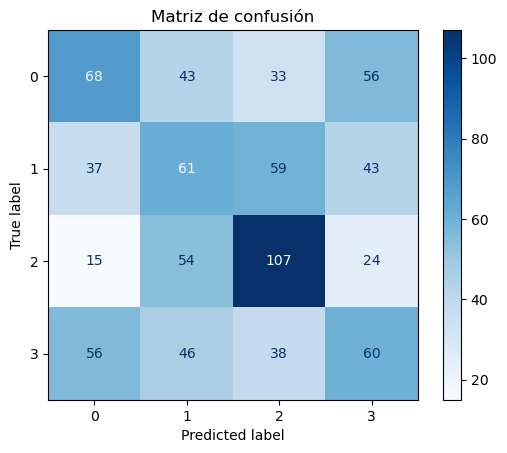

In [11]:
# Cálculo de la matriz de confusión, tomando como parámetros las etiquetas del cojunto de prueba, y las
# predicciones realizadas por el modelo en el conjunto de prueba
svc_cm = confusion_matrix(y_test, _, labels=svc_model.classes_)

# Crear estructura de la matriz de confusión
svc_disp = _(confusion_matrix=svc_cm,
                                  display_labels=svc_model.classes_)

# Graficar matriz de confusión
svc_disp.plot(values_format='', cmap="Blues")
plt.title("Matriz de confusión")
plt.show()

---

# Técnicas avanzadas para la clasificación de secuencias

## Aprendizaje profundo

### MLP (Perceptrón Multicapa)

Es la arquitectura más simple de redes neuronales artificiales. Representa de manera sencilla los 3 tipos de capas que conforman a las redes neuronales artifuciales:

* **Capa de entrada**: conformada por las neuronas que representan a los valores de entrada ($x_i$)
* **Capa(s) oculta(s)**: conformada por las neuronas $h_i^j$ que reciben la suma de los productos de la capa anterior
* **Capa de salida**: la forma la(s) neurona(s) que representa(n) la predicción por la red neuronal. Es decir la capa al final de la arquitectura

#### Representación gráfica de un MLP
<figure>
<img    src="images/MLP.png"
        width="500"
        height="500" />
<figcaption>Fig. 13: Representación gráfica del perceptrón multicapa.
</figure>

#### Introducción a modelos de aprendizaje profundo con PyTorch (ejemplo de implementación de MLP)

**Los modelos de aprendizaje profundo pueden (y generalmente se hace) utilizar aceleradores de hardware como unidades de procesamiento gráfico (GPUs), las mismas que se utilizan para renderizar y procesar gráficos en videojuegos, proyectos de diseño gráfico, renders en arquitectura, etcétera. Una forma sencilla de indicarle al lenguaje de programación que utilizaremos uno de estos aceleradores se muestra en la siguiente celda de código.**

In [18]:
# Definir cpu o gpu para el entrenamiento
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilizando dispositivo: {device}")

Utilizando dispositivo: cuda


En el caso de PyTorch, como trabajamos con un conjunto de datos algo personalizado, hay que realizar un conjunto de acciones previas al entrenamiento del modelo, tales como la creación de los objetos **Dataset** y **DataLoader**. Más información acerca de estos objetos en [este enlace](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
# Creación de una clase tipo "Dataset" para nuestro conjunto de datos de secuencias codificantes y no codificantes
class genomic_sequences_dataset(Dataset):
    def __init__(self, dataset_file, transform=None, train=False):
        self.dataset = pd.read_csv(dataset_file)
        self.transform = transform

        x_train, x_test, y_train, y_test = train_test_split(np.array(self.dataset["padded_sequences"].tolist()), np.array(self.dataset["value"].tolist()), test_size=0.2, train_size=0.8)
        # dos modos entramiento y prueba (train y test)
        if train:
            self.x_data, self.y_data = x_train, y_train
        else:
            self.x_data, self.y_data = x_test, y_test
            

    def __getitem__(self, idx):
        self.padded_sequence = self.x_data[idx]
        self.label = self.y_data[idx]
        self.raw_sequence = self.dataset["sequences"].iloc[idx]
        
        if self.transform:
            sequence = self.transform(self.padded_sequence)
            label = self.transform(self.label)
        
        return sequence, label

    def __len__(self):
        return len(self.dataset["value"])

In [ ]:
# Creación de los conjuntos de datos (Datasets) compatibles con PyTorch
pytorch_dataset_train = genomic_sequences_dataset(dataset_file=gen_path + "genomic_sequences_dataset.csv",
                                            transform=ToTensor(),
                                            train=True)
pytorch_dataset_test = genomic_sequences_dataset(dataset_file=gen_path + "genomic_sequences_dataset.csv",
                                            transform=ToTensor(),
                                            train=False)

In [ ]:
# Definir tamaño de la capa de entrada
in_units = len(X_train[0])

# Definición del modelo
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_units, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256, 2) # Capa de salida de tamaño 2 porque lidiamos con una clasificación binaria
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# Función de entrenamiento
def train(model, dataloader, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Configuramos el modelo para que aprenda
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Hacer una predicción y calcular el error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward() # Cálculo de gradientes
        optimizer.step() # Actualización de los parámetros del modelo
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Pérdida: {loss:>7f} [{current:>5d}/{size:>5d}]")


In [ ]:
# Función de prueba
def test(model, dataloader, loss_fn, losses, accuracies):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Configuramos el modelo para que no actualice sus parámetros
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    losses.append(test_loss)
    accuracies.append(correct)
    print(f"Error de test: \n Precisión: {(100*correct):>0.1f}%, Pérdida promedio: {test_loss:>8f} \n")

### Más arquitecturas de *Deep Learning*

#### Redes neuronales convolucionales (CNN)

Son redes neuronales que emplean la operación conocida como **convolución** en al menos una de sus capas para procesar los datos de entrada. Son utilizadas generalmente en el campo de la **visión computacional**. Son las más usadas en el ramo de la imagenología médica debido a su gran capacidad de abstraer características complejas dentro de imágenes.

La convolución es una operación matemática que involucra el uso de un kernel (o filtro) con los datos de entrada de tal forma que en una dimensión se vería de la siguiente manera:

##### Ilustración de la operación de convolución en una dimensión
<figure>
<img    src="images/Conv1.png"
        width="470"
        height="400">
<figcaption> Fig. 14: Representación gráfica de la operación de convolución
</figure>

#### Transformadores

Los *transformers* fueron la revolución del área de *procesamiento de lenguaje natural* en tareas de traducción y generación de texto cuando fueron introducidos por Vaswani y sus colaboradores en 2017. Se deshicieron de cualquier operación de convolución o de retroalimentación de la información en las redes neuronales, reemplazándolos por **procesos atencionales**. Estas arquitecturas *que ya prestaban atención* entre los valores de entrada y su relación con los valores de salida, sentaron las bases de las inteligencias artificiales más avanzadas, ejemplo de ello es el conocido ChatGPT.

La siguiente figura ilustra la arquitectura general de los transformadores:

<figure>
<img    src="images/Transformer.png"
        width=500
        height=700>
        <figcaption> Fig. 15: Arquitectura básica de los transformadores [6]. 
</figure>

---

# Laboratorio de Innovación Biodigital
En el Laboratorio de Innovación Biodigital realizamos una amplía gama de experimentos que van desde análisis y ciencia de datos, hasta desarrollo de modelos de machine y deep learning. También hacemos otros tipos de análisis, tales como expresión diferencial, plegamiento y alucinación de proteínas y la evaluación de sus interacciones con otras moléculas de interés farmacéutico. Buscamos desarrollar tecnología y estudios que respondan a preguntas cada vez más locas.
<figure>
<img    src="images/Logo BIL con nombre.png"
        width=400
        height=500>
</figure>

<figure>
<img    src="images/BIL.jpeg"
        width=900
        height=600>
</figure>

## Nuestro LinkedIn
<figure>
<img    src="images/Linkedin_BIL.png"
        width=400
        height=400>
</figure>

# Referencias

[1] Clark, D. P., Pazdernik, N. J., & McGehee, M. R. (2019). Molecular biology. Elsevier.

[2] EMBL-EBI (2024) Functional genmics 1. Disponible en: https://www.ebi.ac.uk/training/online/courses/functional-genomics-i-introduction-and-design/

[3] Grešová, K., Martinek, V., Čechák, D., Šimeček, P., & Alexiou, P. (2023). Genomic benchmarks: a collection of datasets for genomic sequence classification. BMC Genomic Data, 24(1), 25.

[4] Angermueller, C., Pärnamaa, T., Parts, L., & Stegle, O. (2016). Deep learning for computational biology. Molecular systems biology, 12(7), 878.

[5] Prince, S. J. (2023). Understanding Deep Learning. MIT press.

[6] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.